In [ ]:
pip install matplotlib seaborn


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import timedelta
import joblib

sns.set(style="whitegrid")

DATA_PATH = "Retail_Dataset2.csv"


In [3]:
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()


Shape: (169211, 11)


,Product_id,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Open,Promo,StateHoliday,SchoolHoliday,Petrol_price
0,786725,Product_0033,Whse_S,Category_005,01/03/2016,16000,1,0,0,0,91
1,786743,Product_1825,Whse_S,Category_006,01/03/2016,50000,1,0,0,0,85
2,786967,Product_0551,Whse_S,Category_030,01/03/2016,3000,1,0,0,0,85
3,786856,Product_0556,Whse_S,Category_030,01/03/2016,1000,1,0,0,0,93
4,899538,Product_1844,Whse_A,Category_018,01/03/2016,7,1,0,0,0,95


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169211 entries, 0 to 169210
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Product_id        169211 non-null  int64 
 1   Product_Code      169211 non-null  object
 2   Warehouse         169211 non-null  object
 3   Product_Category  169211 non-null  object
 4   Date              169211 non-null  object
 5   Order_Demand      169211 non-null  int64 
 6   Open              169211 non-null  int64 
 7   Promo             169211 non-null  int64 
 8   StateHoliday      169211 non-null  object
 9   SchoolHoliday     169211 non-null  int64 
 10  Petrol_price      169211 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 14.2+ MB


In [5]:
df.describe()


,Product_id,Order_Demand,Open,Promo,SchoolHoliday,Petrol_price
count,1.692110e+05,1.692110e+05,169211.000000,169211.000000,169211.000000,169211.000000
mean,9.528887e+05,5.248118e+03,0.817742,0.395364,0.133401,87.986183
std,5.555751e+04,3.116296e+04,0.386058,0.488930,0.340009,4.909978
min,6.909430e+05,0.000000e+00,0.000000,0.000000,0.000000,80.000000
25%,9.054275e+05,2.000000e+01,1.000000,0.000000,0.000000,84.000000
50%,9.526430e+05,3.000000e+02,1.000000,0.000000,0.000000,88.000000
75%,1.001416e+06,2.000000e+03,1.000000,1.000000,0.000000,92.000000
max,1.048574e+06,2.500000e+06,1.000000,1.000000,1.000000,96.000000


In [6]:
df.isna().sum()


Product_id          0
Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
Open                0
Promo               0
StateHoliday        0
SchoolHoliday       0
Petrol_price        0
dtype: int64

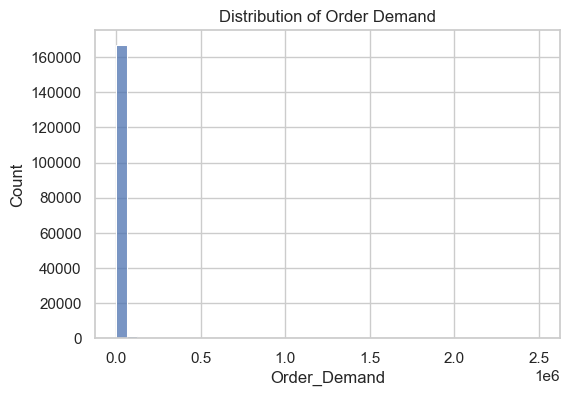

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(df["Order_Demand"], bins=40)
plt.title("Distribution of Order Demand")
plt.show()


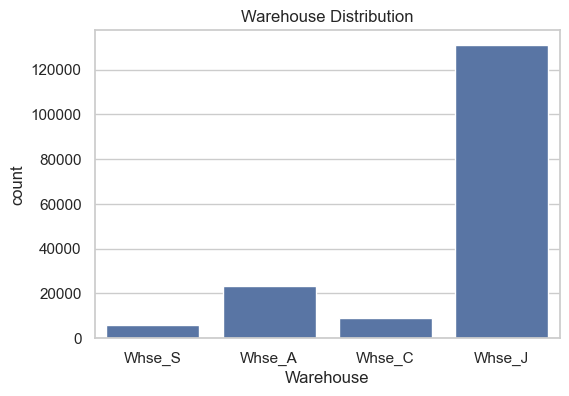

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["Warehouse"])
plt.title("Warehouse Distribution")
plt.show()


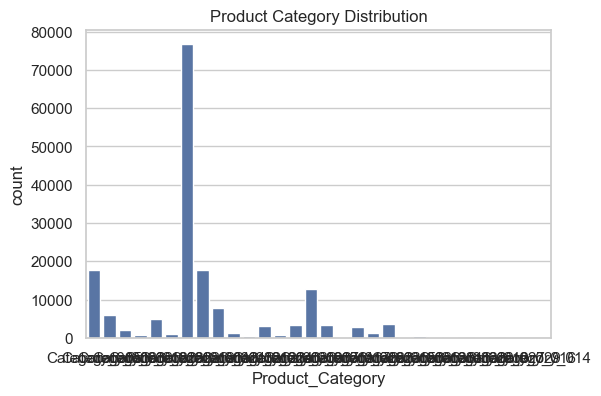

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["Product_Category"])
plt.title("Product Category Distribution")
plt.show()


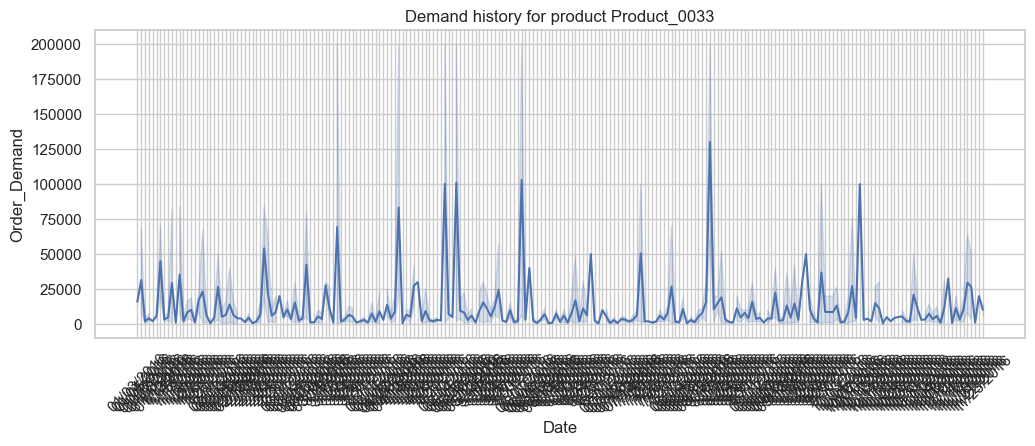

In [10]:
sample_prod = df["Product_Code"].unique()[0]
temp = df[df["Product_Code"] == sample_prod]

plt.figure(figsize=(12,4))
sns.lineplot(x=temp["Date"], y=temp["Order_Demand"])
plt.title(f"Demand history for product {sample_prod}")
plt.xticks(rotation=45)
plt.show()


In [11]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

df['Order_Demand'] = (
    df['Order_Demand'].astype(str)
    .str.replace(',', '')
    .str.replace(' ', '')
    .replace('nan', np.nan)
)

df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce').fillna(0)


In [12]:
agg = df.groupby(
    ['Date','Product_Code','Warehouse','Product_Category'], as_index=False
)['Order_Demand'].sum().rename(columns={'Order_Demand':'sales'})


In [13]:
# date features
agg['day'] = agg['Date'].dt.day
agg['month'] = agg['Date'].dt.month
agg['year'] = agg['Date'].dt.year
agg['dayofweek'] = agg['Date'].dt.dayofweek
agg['is_weekend'] = agg['dayofweek'].isin([5,6]).astype(int)

# mean sales per product
prod_mean = agg.groupby('Product_Code')['sales'].mean().rename('prod_sales_mean')
agg = agg.merge(prod_mean, on='Product_Code', how='left')

# label encoding
le_wh = LabelEncoder()
agg['Warehouse_le'] = le_wh.fit_transform(agg['Warehouse'])

le_cat = LabelEncoder()
agg['Product_Category_le'] = le_cat.fit_transform(agg['Product_Category'])


In [14]:
df_list = []

for (prod, wh), g in agg.groupby(['Product_Code','Warehouse']):
    g = g.sort_values("Date").set_index("Date")

    g["lag_1"]  = g["sales"].shift(1)
    g["lag_7"]  = g["sales"].shift(7)
    g["lag_14"] = g["sales"].shift(14)
    g["lag_28"] = g["sales"].shift(28)

    g["rmean_7"]  = g["sales"].shift(1).rolling(7).mean()
    g["rmean_28"] = g["sales"].shift(1).rolling(28).mean()

    g["rstd_7"] = g["sales"].shift(1).rolling(7).std()
    g["rmin_7"] = g["sales"].shift(1).rolling(7).min()
    g["rmax_7"] = g["sales"].shift(1).rolling(7).max()

    g["trend"] = np.arange(len(g))

    df_list.append(g.reset_index())

df_feat = pd.concat(df_list, axis=0)
df_feat = df_feat.dropna()


In [15]:
df_feat = df_feat.sort_values("Date")
last_date = df_feat["Date"].max()
cutoff = last_date - timedelta(days=30)

train_df = df_feat[df_feat["Date"] <= cutoff]
test_df  = df_feat[df_feat["Date"] > cutoff]

features = [
    'day','month','year','dayofweek','is_weekend','prod_sales_mean',
    'Warehouse_le','Product_Category_le',
    'lag_1','lag_7','lag_14','lag_28',
    'rmean_7','rmean_28','rstd_7','rmin_7','rmax_7','trend'
]

target = "sales"

X_train = train_df[features]
y_train = train_df[target]
X_test  = test_df[features]
y_test  = test_df[target]


In [22]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=31,
)

X_train_np = np.asarray(X_train)
y_train_np = np.asarray(y_train)
X_test_np = np.asarray(X_test)
y_test_np = np.asarray(y_test)

model.fit(X_train_np, y_train_np)
preds = model.predict(X_test_np)



e:\UTS_MLOPS\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\UTS_MLOPS\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_np, preds))

mae  = mean_absolute_error(y_test_np, preds)
mape = np.mean(np.abs((y_test_np - preds) / (y_test_np + 1e-5))) * 100
r2   = r2_score(y_test_np, preds)

eval_table = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "MAPE (%)", "R²"],
    "Value": [rmse, mae, mape, r2]
})
eval_table


,Metric,Value
0,RMSE,6.920230e+04
1,MAE,1.211466e+04
2,MAPE (%),1.022615e+09
3,R²,-5.889664e-02


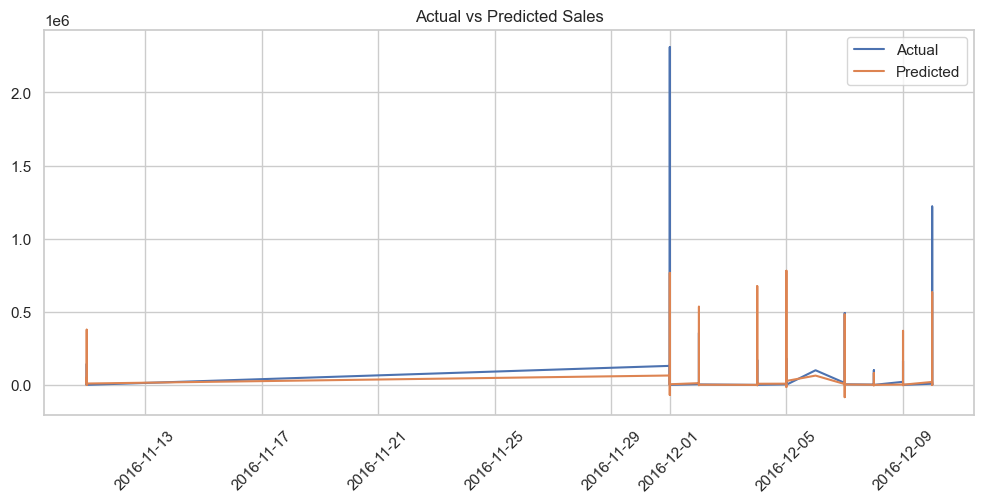

In [27]:
plt.figure(figsize=(12,5))
plt.plot(test_df["Date"], y_test.values, label="Actual")
plt.plot(test_df["Date"], preds, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.xticks(rotation=45)
plt.show()


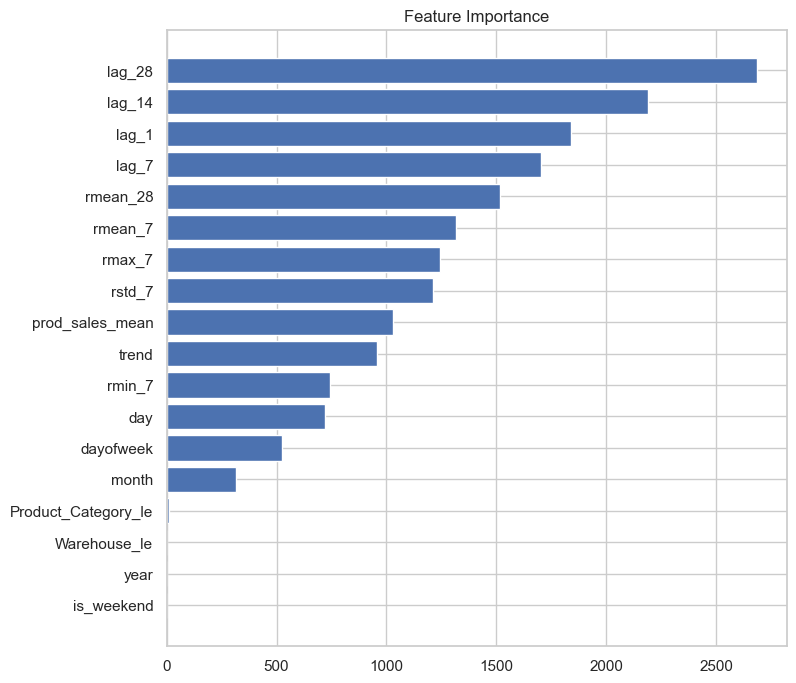

,feature,importance
11,lag_28,2685
10,lag_14,2187
8,lag_1,1839
9,lag_7,1703
13,rmean_28,1515
12,rmean_7,1316
16,rmax_7,1243
14,rstd_7,1212
5,prod_sales_mean,1029
17,trend,955


In [29]:
importances = model.feature_importances_
feature_names = X_train.columns  
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,8))
plt.barh(fi["feature"], fi["importance"])
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

fi
